<center>
    <h1>Identifying the Human Values behind Arguments</h1>
    <h1>04 - Main Model</h1>
    <h2>Natural Language Processing</h2>
    <h3>Antonio Politano, Enrico Pittini, Riccardo Spolaor and Samuele Bortolato</h3>
    <h4>antonio.politano2@studio.unibo.it, enrico.pittini@studio.unibo.it, riccardo.spolaor@studio.unibo.it, samuele.bortolato@studio.unibo.it</h4>
</center>

---

In this notebook a *Main Model* is proposed for the *Identifying the Human Values behind Arguments* task and evaluated on the provided dataset.

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `src` folder.

In [1]:
# Settings for autoreloading.

%load_ext autoreload
%autoreload 2

In [2]:
# Settings for reproducibility.

from src.utils.seeder import set_random_seed

SEED = 42
set_random_seed(SEED)

## Download of the Dataset

The dataset is given as already split into train and test. In particular, these two datasets are divided into:
* The `arguments` set, which contains instances expressing a position on a specific argument. They are represented as follows:
    * An argument *premise*.
    * The *stance* regarding the argument (either *in favor* or *against*).
    * The *conclusion* on the topic.
* The respective `labels` set, which is comprised of a *multi-label* vector specifying which *Human Values* are related to the correspomnding argument. Hence an argument can refer to more than one *Human Value*. The total number of considered *Human Value* labels is $20$.

In [3]:
from src.datasets.dataset_builder import get_dataframes

arguments_train_df, labels_train_df = get_dataframes('data', 'training')
arguments_test_df, labels_test_df = get_dataframes('data', 'validation')

In [4]:
TARGETS = labels_train_df.columns.to_list()

The validation dataset is obtained by taking a randomly selected $20 \%$ portion of the training dataset. The *seed* provides reproducible results. Furthermore, the `train_test_split` *scikit-learn* function in used to guarantee the split maintains label balance.

In [5]:
from src.datasets.dataset_builder import split_dataframes

(arguments_train_df, labels_train_df), (arguments_val_df, labels_val_df) = \
    split_dataframes(arguments_train_df, labels_train_df, seed=SEED)

# Model and Tokenizer Definition

The selected model for the task is the *bert-base-uncased pre-trained language model* and the respective *tokenizer*. 

The special tokens `[AGN]`, `[FAV]` are added to the tokenizer to encode the stance of each input instance.

The model and tokenizer have been instantiated to handle the *multi-label classification* problem type.

In [6]:
from torch import cuda
from transformers import logging

MODEL_NAME = 'bert-base-uncased'
DEVICE = 'cuda' if cuda.is_available() else 'cpu'

# Set verbosity at "error" level
logging.set_verbosity_error()

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, problem_type='multi_label_classification')

# Add the tokens encoding the stance to the tokenizer.
tokenizer.add_tokens(['[FAV]', '[AGN]'], special_tokens=True)

# Build a dictionary to encde the stance.
stance_encoder = {'in favor of': '[FAV]', 'against': '[AGN]'}

In [8]:
from src.models.transformer_model  import get_transformer_model

model = get_transformer_model(MODEL_NAME, num_labels=len(TARGETS),
                              tokenizer=tokenizer, device=DEVICE)

In [9]:
print('Model structure:')
print(model)

Model structure:
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30524, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

## Training

### Create Dataloaders

The train, validation and test dataloaders are created. The *batch size* for the train dataloader is set at $8$, while the one for the validation and test dataloader is set at $16$.

Data Augmentation is applied only for the train dataloader. In particular, one of the following inputs of each argument instance is randomly selected when the batch is loaded.
* The premise.
* The conclusion.
* The premise followed by the stance and the conclusion.

Shuffling is applied just on the train dataloader.

In [10]:
from src.datasets.dataloader_builder import get_dataloader

BATCH_SIZE_TRAIN = 8
BATCH_SIZE_EVAL = 16

train_loader = get_dataloader(arguments_train_df, labels_train_df, tokenizer,
                             stance_encoder, is_transformer=True, 
                             batch_size=BATCH_SIZE_TRAIN, shuffle=True,
                             use_augmentation=True)
val_loader = get_dataloader(arguments_val_df, labels_val_df, tokenizer,
                             stance_encoder, is_transformer=True,
                             batch_size=BATCH_SIZE_EVAL, shuffle=False,
                             use_augmentation=False)
test_loader = get_dataloader(arguments_test_df, labels_test_df, tokenizer,
                             stance_encoder, is_transformer=True,
                             batch_size=BATCH_SIZE_EVAL, shuffle=False,
                             use_augmentation=False)

### Training parameters

The following training parameters have been selected:
* The number of *epochs* is set at $15$.
* *Adam* is used as an optimizer.
    * The *learning rate* of the *bert language model* part of the model is set at $2e-05$, to apply a less severe tuning of the language model.
    * The *learning rate* of the *classification head* of the model is increased at $1e-03$ to tune the model more specifically in its classification task.
* The number of *validation steps* is set at $200$. They indicate after how many batch steps the evaluation of the model on the validation set occurs.
* The chosen loss function is the *Focal Loss*. It downweights easy examples to classify and upweights hard examples by weighting to the classical *binary cross-entropy* to focus the training on the hard samples to classify. The loss function is weighted to handle also the class unbalance which is estimated on the label frequencies of the train set.
* A checkpoint monitor is introduced to save the best model weights according to the validation set best evaluation scores.
* An early stopping monitor is introduced to stop the training if the evaluation score does not improve after a certain number of steps.

In [11]:
import os
from torch.optim import Adam
from src.training.training_utils import Checkpoint, EarlyStopping, FocalLoss

# Set the number of epochs.
EPOCHS = 15
# Set the learning rates for the Bert model and the Classification head.
LEARNING_RATE_BERT = 2e-05
LEARNING_RATE_CLASSIFIER = 1e-03
# Set how many training steps to use for validation.
STEPS_VALIDATE = 200

# Set the loss function.
train_labels_frequencies = (labels_train_df.sum() / len(labels_train_df))
train_labels_frequencies = train_labels_frequencies.to_numpy()
loss_function = FocalLoss(alpha=train_labels_frequencies, gamma=1.5)

# Set the optimizer.
optimizer = Adam(params=[
    { 'params': model.bert.parameters(), 'lr': LEARNING_RATE_BERT },
    { 'params': model.dropout.parameters(), 'lr': LEARNING_RATE_CLASSIFIER },
    { 'params': model.classifier.parameters(), 'lr': LEARNING_RATE_CLASSIFIER }
    ])

# Set the checkpoints and the early stopping monitor.
checkpoint = Checkpoint(model, path=os.path.join('models', 'main_model.pth'))
early_stopping = EarlyStopping()

### Training

The training is performed for the given number of epochs. The model is evaluated on the validation set multiple times per epoch and at the end of each one to accurately track the performances and the overfitting of the model.

The evaluation is computed while measuring the *F1 score* on the validation set. Checkpointing on the best model weight is applied during the training procedure in order to save the weights of the model that make it reach the highest validation *F1 score*.

In [12]:
from src.training.training import train

# Train the model.
train_loss_history, val_loss_history, val_f1_macro_history = train(
    train_loader, val_loader, model, optimizer, loss_function, DEVICE,
    epochs=EPOCHS, steps_validate=STEPS_VALIDATE, checkpoint=checkpoint,
    early_stopping=early_stopping, reload_best_weights=True,
    use_threshold_selection=True)

epoch: 1/15, 199/540, 41s 207ms/step, loss: 0.0626                
validate: 5s, validation loss: 0.0564, validation f1 macro: 42.4 %                
epoch: 1/15, 399/540, 81s 202ms/step, loss: 0.0593                
validate: 5s, validation loss: 0.0519, validation f1 macro: 46.9 %                
epoch: 1/15, 540/540, 129s 239ms/step, loss: 0.0581                
---------------------------------------------------------------
epoch: 1/15, 129s, loss: 0.0581, val loss:, 0.0515, val f1 macro: 48.1 %
epoch: 2/15, 199/540, 33s 165ms/step, loss: 0.0516                
validate: 5s, validation loss: 0.0497, validation f1 macro: 50.2 %                
epoch: 2/15, 399/540, 71s 178ms/step, loss: 0.0512                
validate: 5s, validation loss: 0.0496, validation f1 macro: 50.6 %                
epoch: 2/15, 540/540, 100s 184ms/step, loss: 0.0512                
---------------------------------------------------------------
epoch: 2/15, 100s, loss: 0.0512, val loss:, 0.0489, val f1 macr

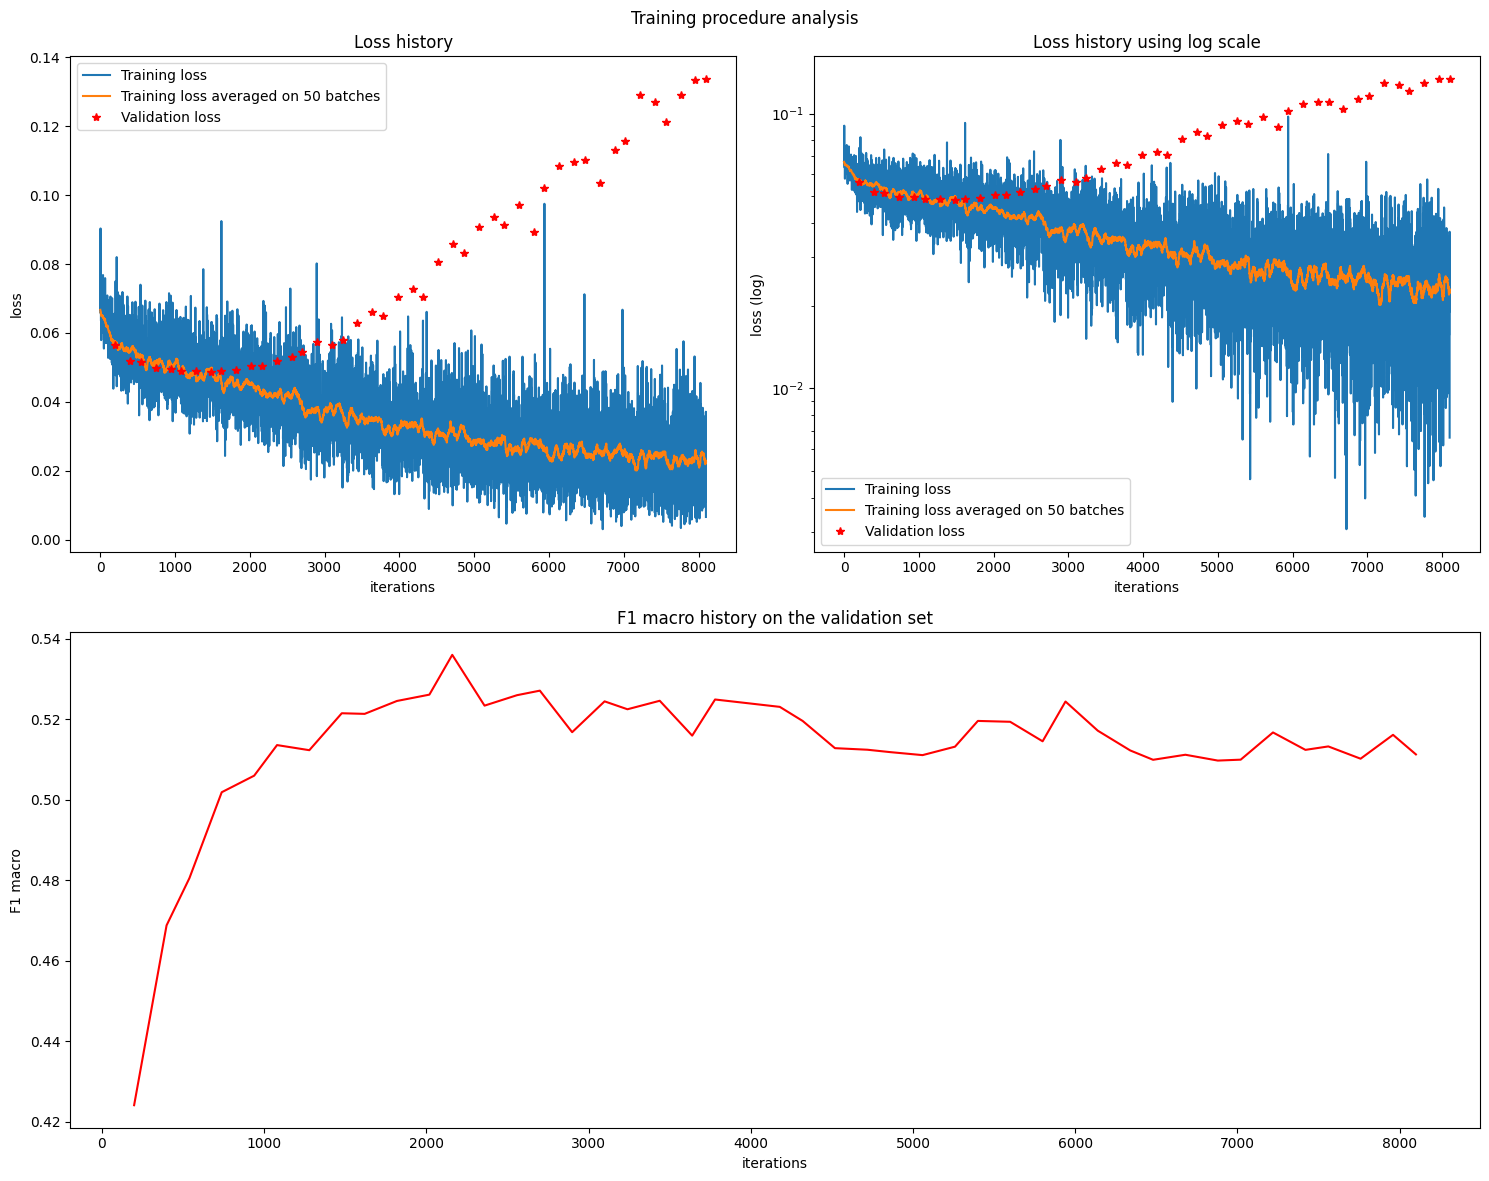

In [13]:
from src.training.training_analysis import plot_training_history

plot_training_history(train_loss_history, val_loss_history,
                      val_f1_macro_history)

# Model Evaluation

## Threshold selection
In this section, the threshold selection procedure is illuatrated

The *Receiver Operating Characteristic Curves* illustrate the true and false positive rate relation when the threshold varies on each label. A threshold selection operation is necessary to obtain better results.

Macro-averaged One-vs-Rest ROC AUC score:
0.83


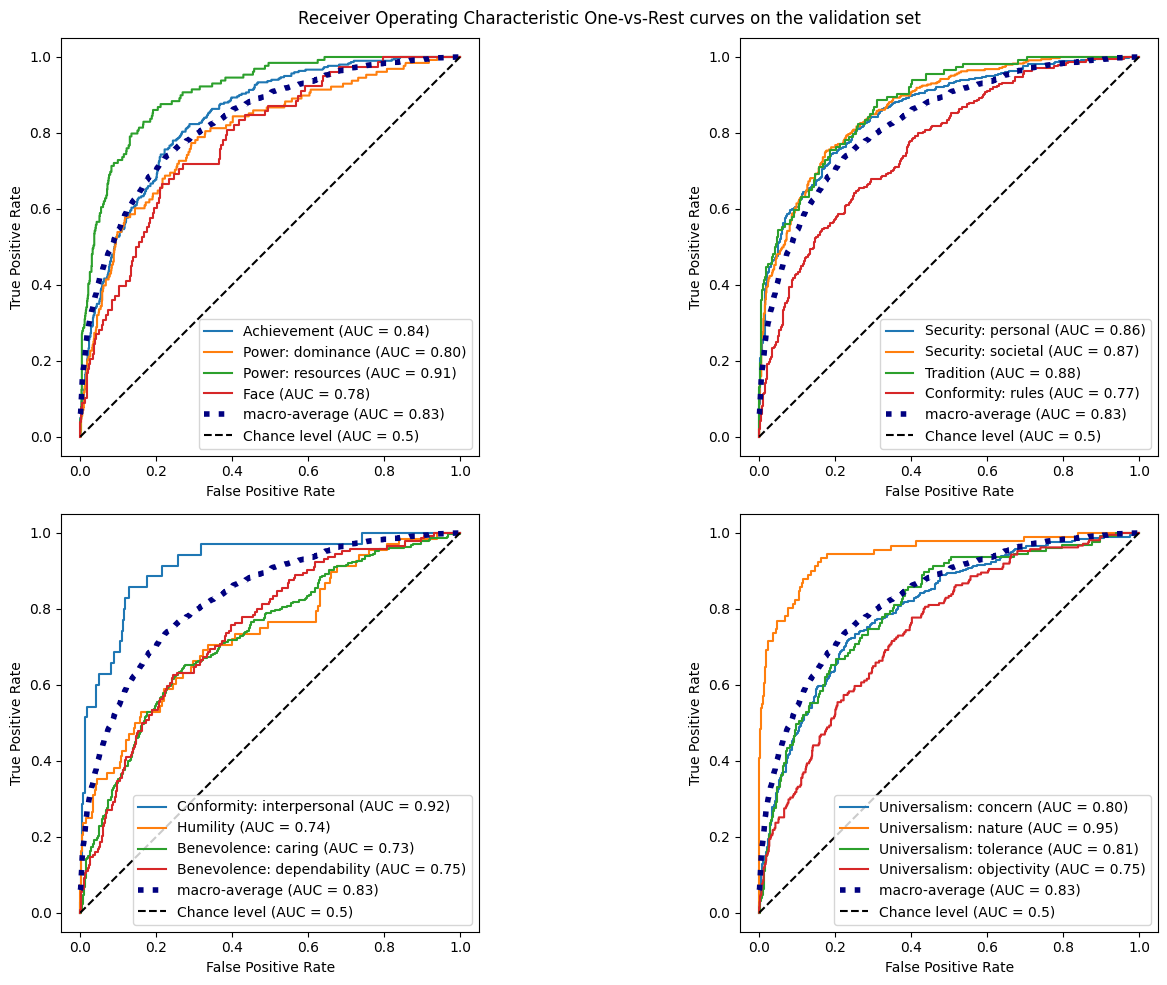

In [15]:
from src.evaluation.evaluation import get_dataset_prediction_scores
from src.evaluation.evaluation_analysis import plot_roc_curves

y_scores, y_true = get_dataset_prediction_scores(model, val_loader, DEVICE)
plot_roc_curves(y_true, y_scores, TARGETS, 'validation')

To select the best thresholds, the *precision*, *recall* and *F1-score* have been computed on all possible thresholds on the validation dataset for all possible labels.

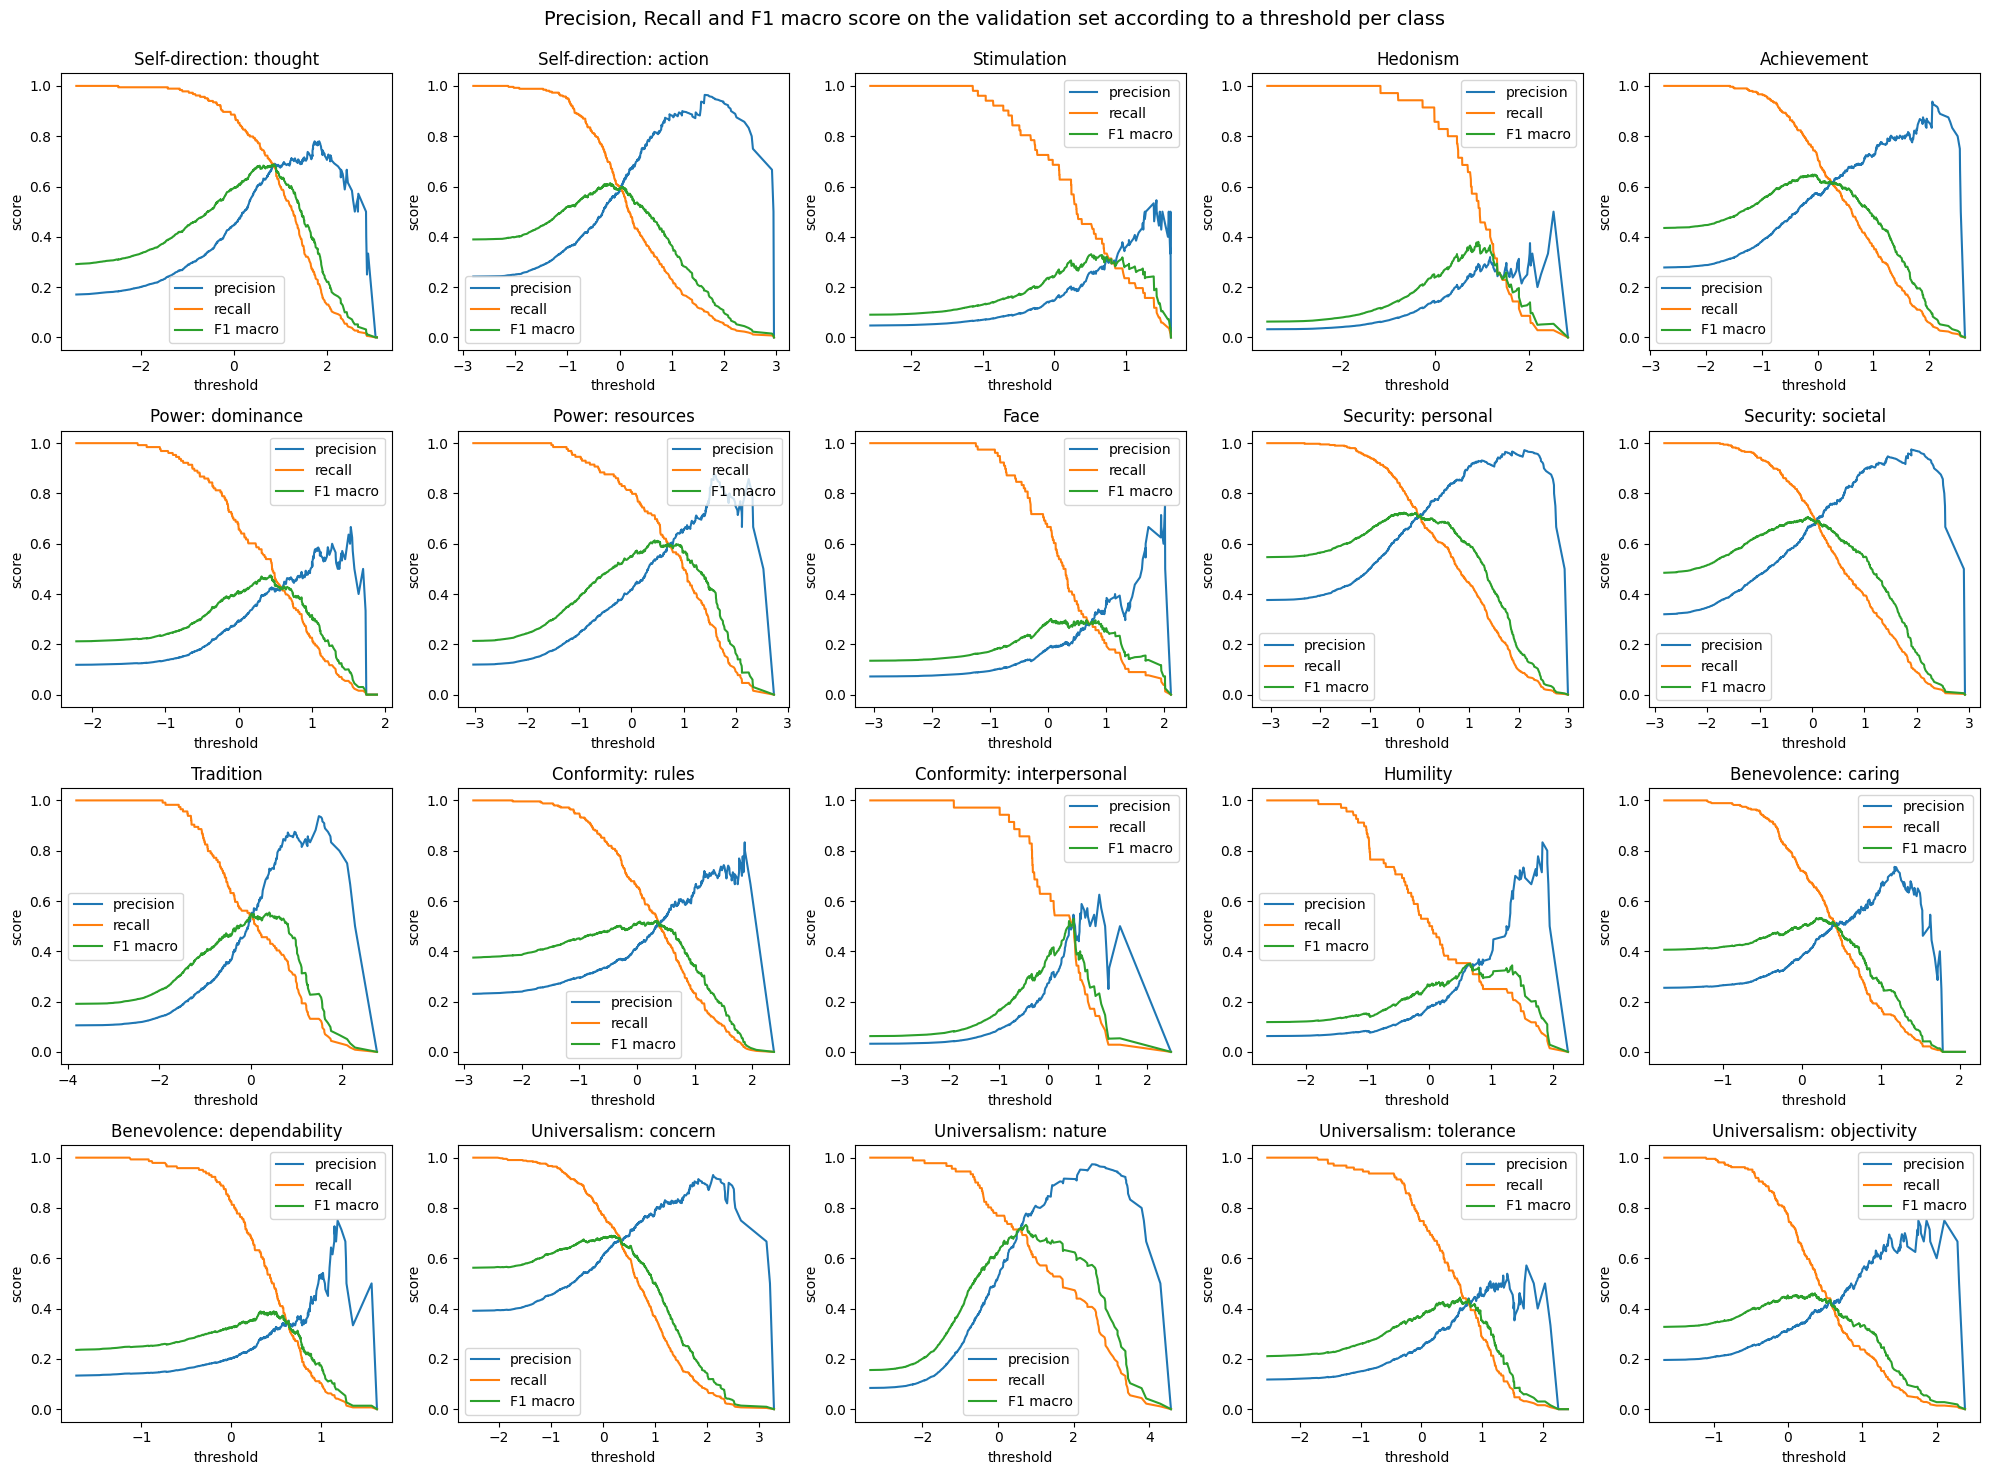

In [16]:
from src.evaluation.evaluation_analysis import (
    plot_precision_recall_f1_macro_curves)

plot_precision_recall_f1_macro_curves(y_true, y_scores, TARGETS, 'validation')

The thresholds that for each label maximize the *F1 score* on the validation set have been selected.

In [17]:
from src.evaluation.evaluation import get_best_thresholds
import numpy as np

# Get the best thresholds.
thresholds_per_target = get_best_thresholds(y_true, y_scores)

# Save the best thresholds.
np.save(os.path.join('models', 'main_model_thresholds.npy'),
        thresholds_per_target)

for target, thresh in zip(TARGETS, thresholds_per_target):
    print(f'"{target}" best threshold: {thresh:.4f}')

"Self-direction: thought" best threshold: 0.8513
"Self-direction: action" best threshold: -0.1767
"Stimulation" best threshold: 0.5179
"Hedonism" best threshold: 0.9175
"Achievement" best threshold: -0.0880
"Power: dominance" best threshold: 0.4391
"Power: resources" best threshold: 0.4459
"Face" best threshold: 0.0491
"Security: personal" best threshold: -0.3157
"Security: societal" best threshold: -0.0767
"Tradition" best threshold: 0.4053
"Conformity: rules" best threshold: 0.3270
"Conformity: interpersonal" best threshold: 0.5056
"Humility" best threshold: 0.6591
"Benevolence: caring" best threshold: 0.2294
"Benevolence: dependability" best threshold: 0.4775
"Universalism: concern" best threshold: 0.1603
"Universalism: nature" best threshold: 0.7367
"Universalism: tolerance" best threshold: 0.6358
"Universalism: objectivity" best threshold: 0.3625


## Evaluation on the Validation set

In this section the model performances are evaluated on the validation set.

In [18]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, val_loader, DEVICE)

# Compute Validation F1 macro score.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the validation set with base threshold 0:', 
      f'{f1_macro:.3f}')

Validation f1-score macro on the validation set with base threshold 0: 0.480


In [19]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, val_loader, DEVICE,
                                         thresholds_per_target)

# Compute Validation F1 macro score with threshold selection.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the validation set with threshold',
      f'selection: {f1_macro:.3f}')

Validation f1-score macro on the validation set with threshold selection: 0.536


In [20]:
from src.evaluation.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'validation')

Classification report for the validation set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.69      0.69      0.69       184
    Self-direction: action       0.55      0.69      0.61       261
               Stimulation       0.26      0.45      0.33        51
                  Hedonism       0.30      0.54      0.38        35
               Achievement       0.57      0.76      0.65       300
          Power: dominance       0.43      0.54      0.48       128
          Power: resources       0.54      0.71      0.62       129
                      Face       0.19      0.67      0.30        78
        Security: personal       0.66      0.81      0.72       406
        Security: societal       0.67      0.75      0.71       345
                 Tradition       0.74      0.45      0.56       114
         Conformity: rules       0.50      0.54      0.52       249
 Conformity: interpersonal       0.56      0.51      0.54        35
 

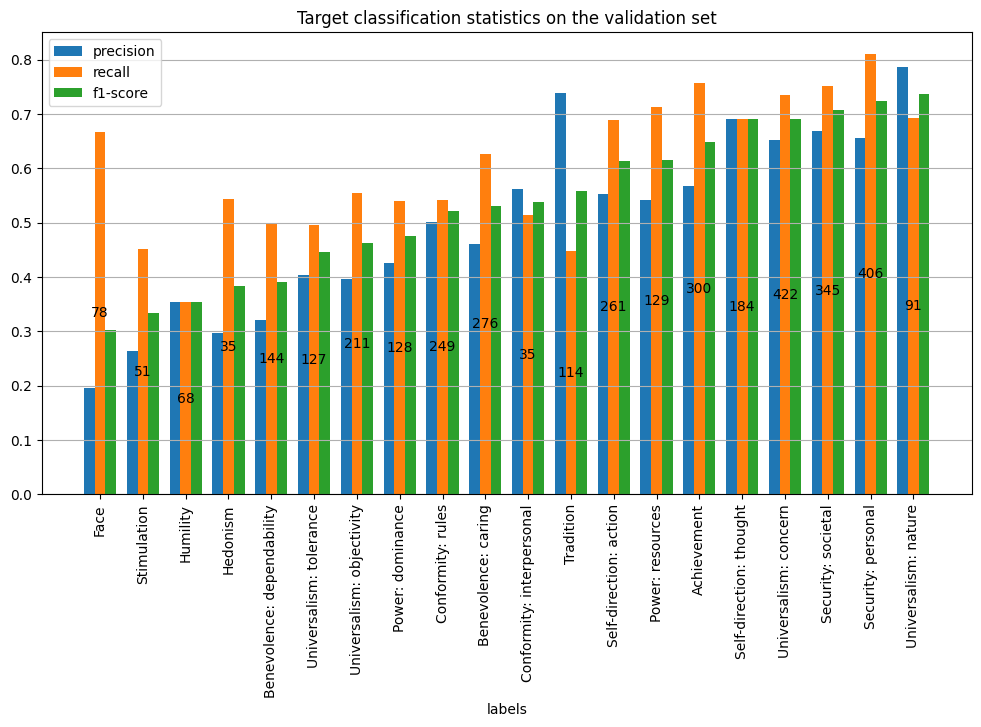

In [21]:
from src.evaluation.evaluation_analysis import \
    plot_targets_classification_statistics

plot_targets_classification_statistics(y_true, y_pred, TARGETS, 'validation')

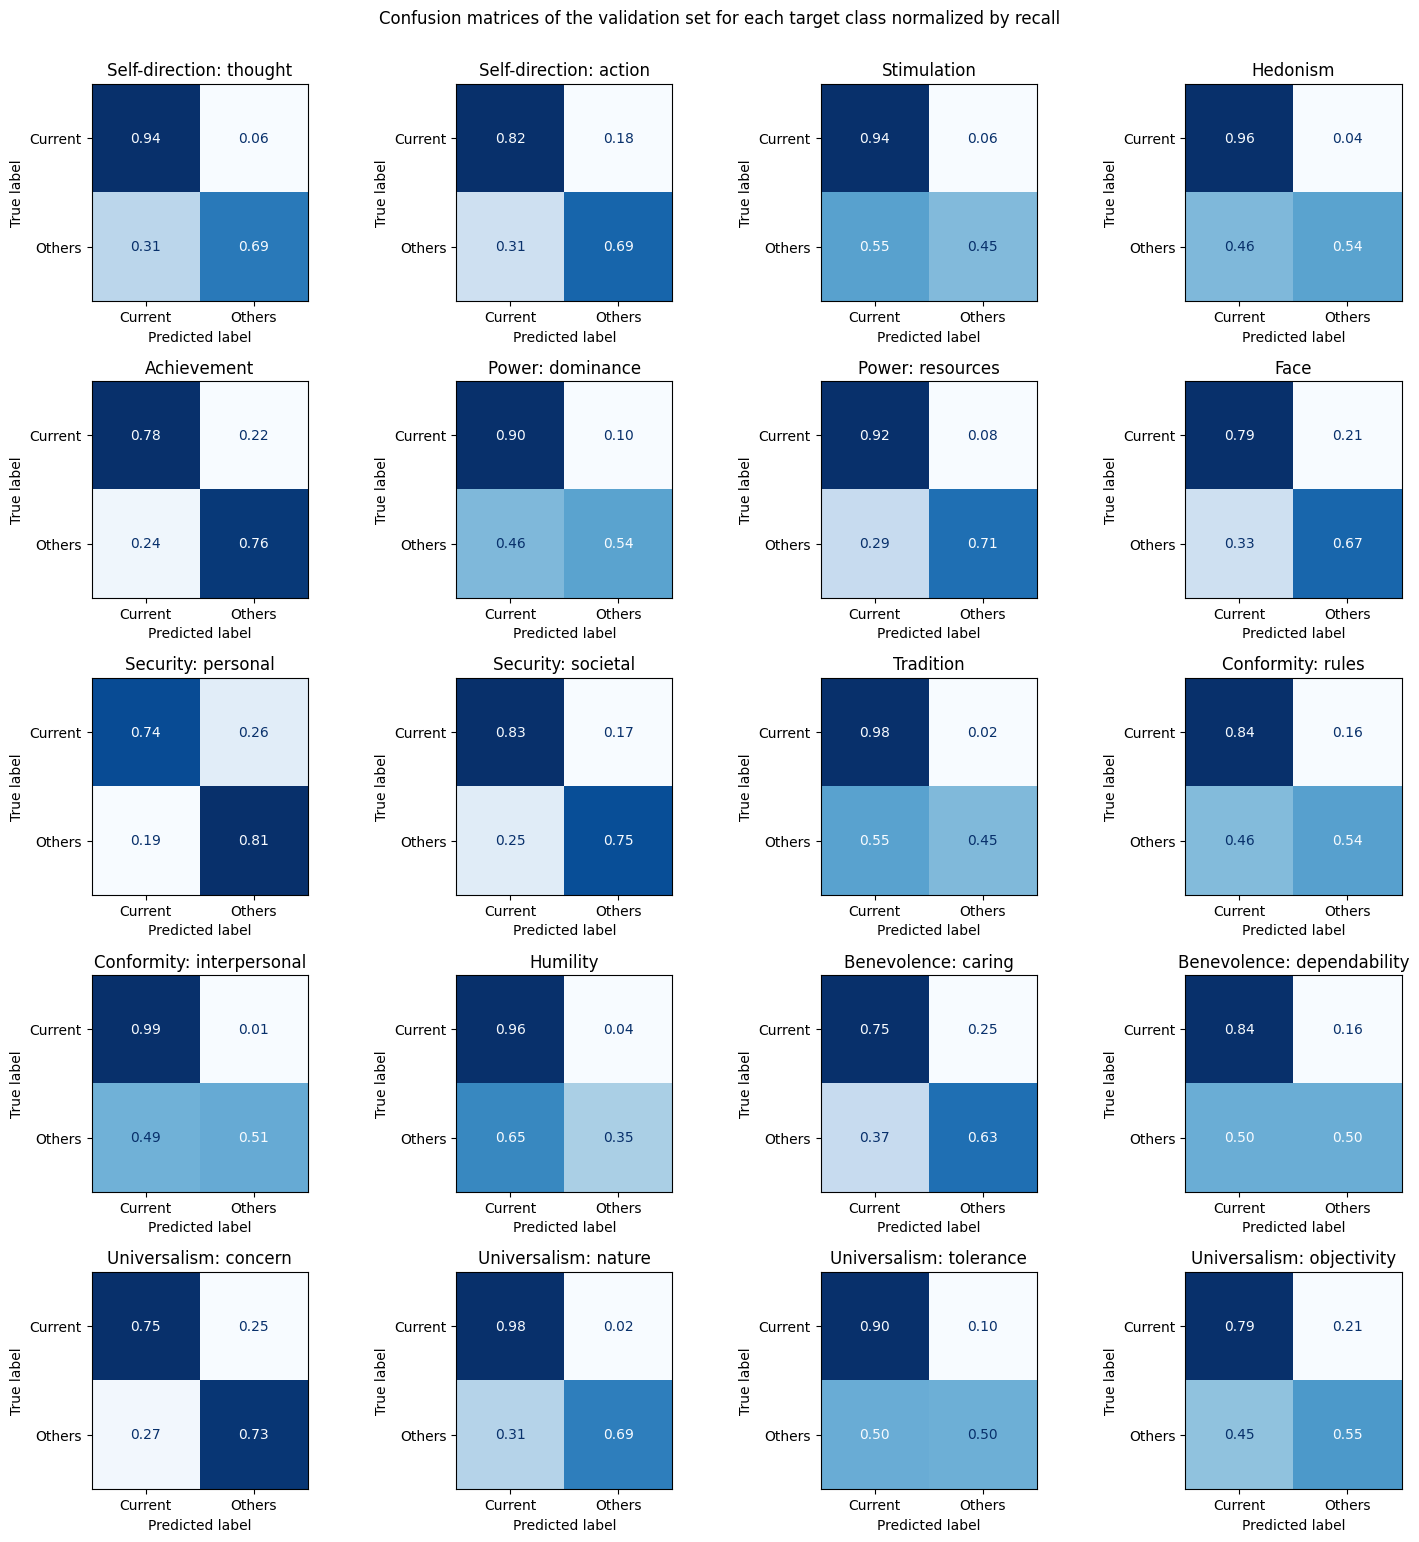

In [22]:
from src.evaluation.evaluation_analysis import plot_confusion_matrices

plot_confusion_matrices(y_true, y_pred, TARGETS, 'validation',
                        normalize_by='recall')

## Evaluation on the Test set

In this section the model performances are evaluated on the test set.

In [23]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, test_loader, DEVICE)

# Compute Test F1 macro score.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the test set with base threshold 0:',
      f'{f1_macro:.3f}')

Validation f1-score macro on the test set with base threshold 0: 0.444


In [24]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, test_loader, DEVICE,
                                         thresholds_per_target)

# Compute Test F1 macro score with threshold selection.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the test set with threshold selection:',
      f'{f1_macro:.3f}')

Validation f1-score macro on the test set with threshold selection: 0.451


In [25]:
from src.evaluation.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'test')

Classification report for the test set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.56      0.44      0.49       251
    Self-direction: action       0.48      0.54      0.51       496
               Stimulation       0.28      0.28      0.28       138
                  Hedonism       0.40      0.53      0.45       103
               Achievement       0.61      0.71      0.65       575
          Power: dominance       0.32      0.30      0.31       164
          Power: resources       0.40      0.54      0.46       132
                      Face       0.18      0.49      0.27       130
        Security: personal       0.65      0.86      0.74       759
        Security: societal       0.60      0.64      0.62       488
                 Tradition       0.65      0.31      0.42       172
         Conformity: rules       0.53      0.56      0.55       455
 Conformity: interpersonal       0.32      0.18      0.23        60
       

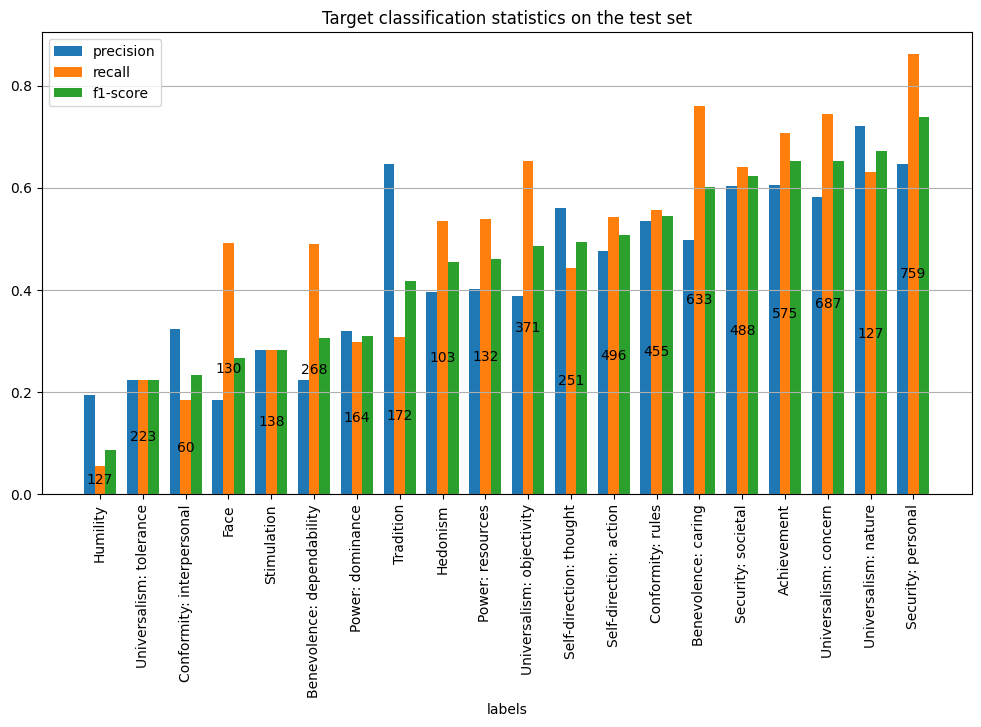

In [26]:
from src.evaluation.evaluation_analysis import \
    plot_targets_classification_statistics

plot_targets_classification_statistics(y_true, y_pred, TARGETS, 'test')

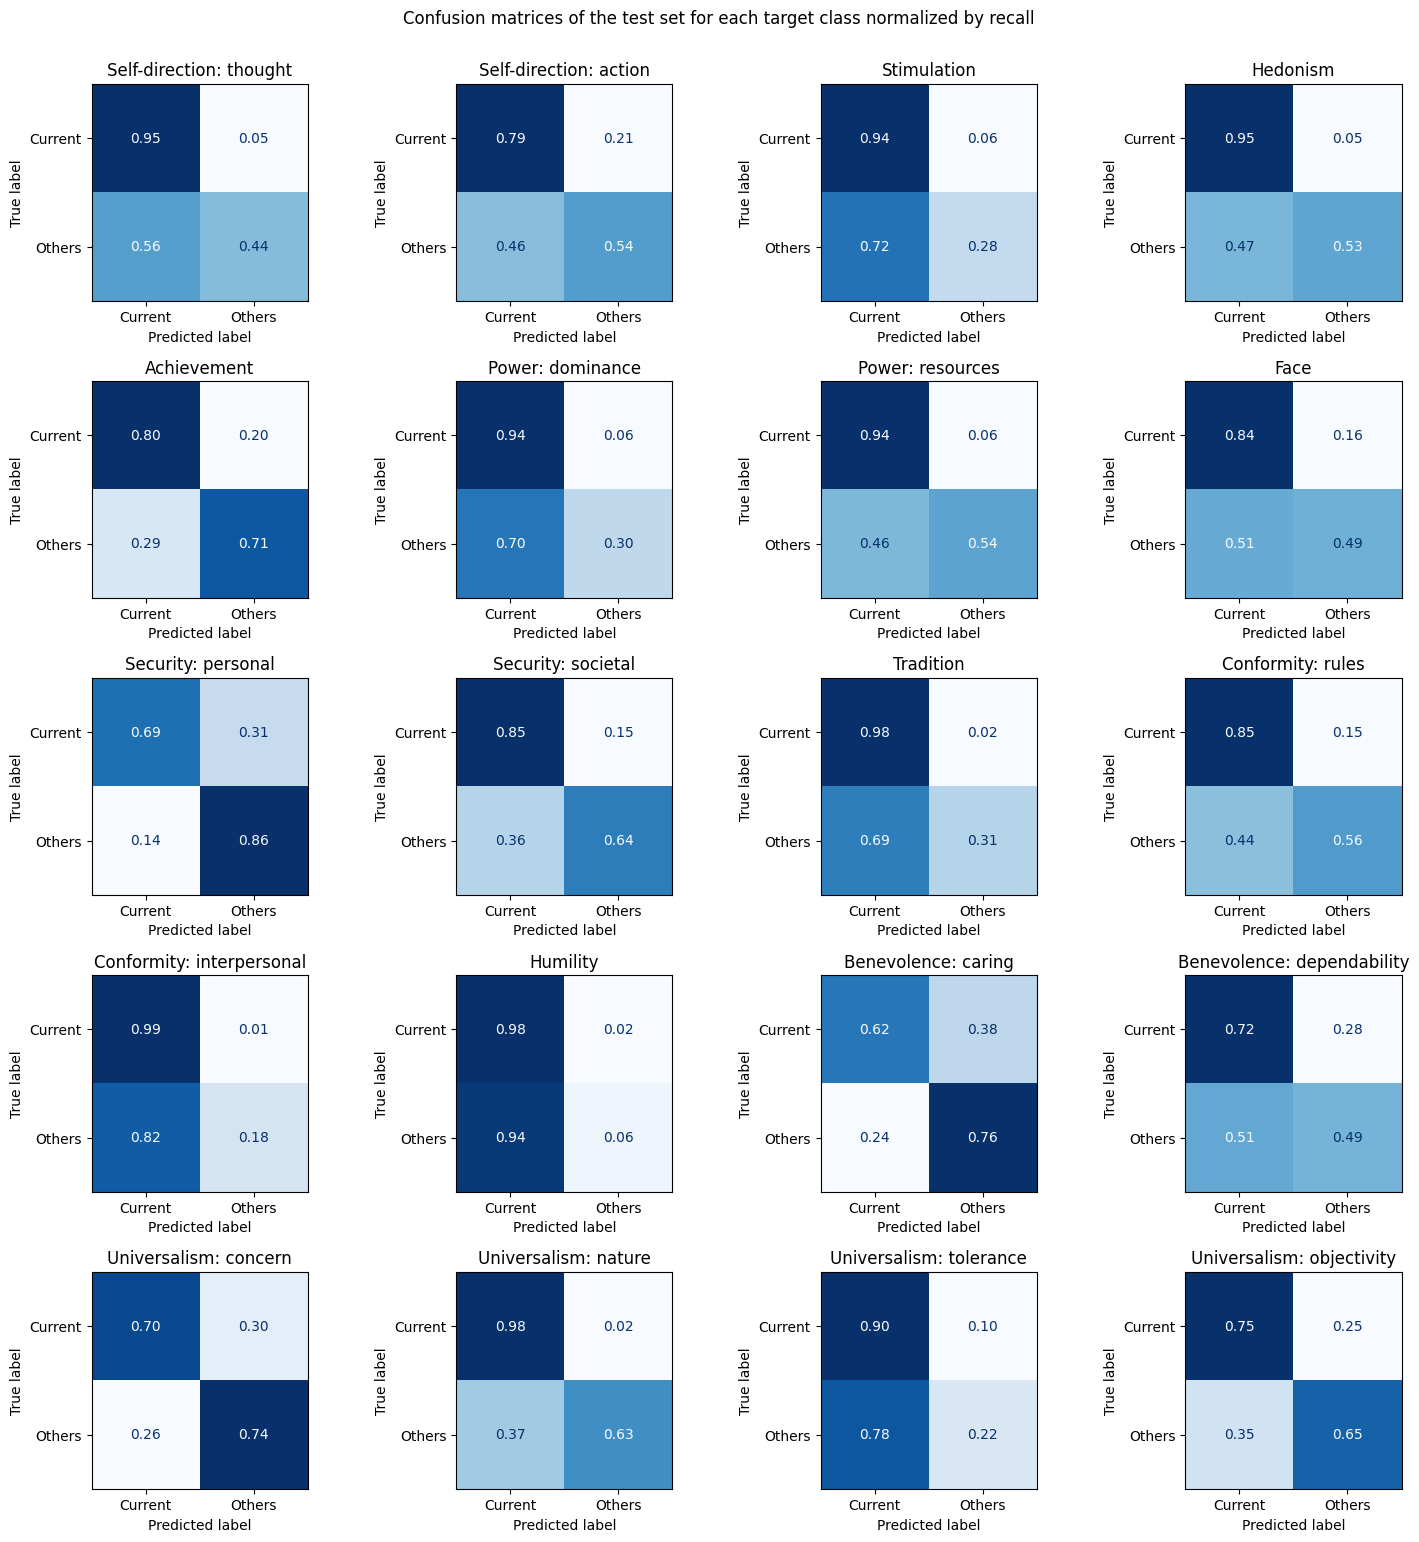

In [28]:
from src.evaluation.evaluation_analysis import plot_confusion_matrices

plot_confusion_matrices(y_true, y_pred, TARGETS, 'test', normalize_by='recall')

# Error Analysis on the Test Set

In this section the actual error analysis task is performed.

The worst $200$ predicted instances in terms of target label *accuracy* are selected.

In [29]:
from src.evaluation.error_analysis import get_k_worst_predicted_instances

worst_predicted_instances, worst_predicted_instances_targets = \
    get_k_worst_predicted_instances(arguments_test_df, labels_test_df,
    y_true, y_pred, n_worst_instances=200)

In [30]:
worst_predicted_instances.head()

,Conclusion,Stance,Premise,Labels
1341,The vow of celibacy should be abandoned,against,the vow of celibacy is too important to do awa...,"[Achievement, Face, Tradition, Conformity: rul..."
880,The vow of celibacy should be abandoned,in favor of,the vow of celibacy should be abandoned becaus...,"[Stimulation, Hedonism, Face, Conformity: rule..."
1768,We should not have illegal immigrants!,in favor of,We can only employ people in understaffed job ...,"[Security: personal, Security: societal, Confo..."
1085,Social media brings more harm than good,in favor of,you dont know whats real or fake on social media,"[Achievement, Security: societal, Conformity: ..."
366,The vow of celibacy should be abandoned,in favor of,"i consider it a sensitive issue, however, beca...","[Self-direction: action, Stimulation, Hedonism..."


In [31]:
worst_predicted_instances_targets.head()

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
1341,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0
880,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0
1768,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,1,0
1085,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1
366,0,1,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0


Among these considered worst predicted instances, the ones having stances *in favor of* the argument are roughly double the number of the ones *against*, suggesting that the model predicts more accurately the arguments with stances *against* them.

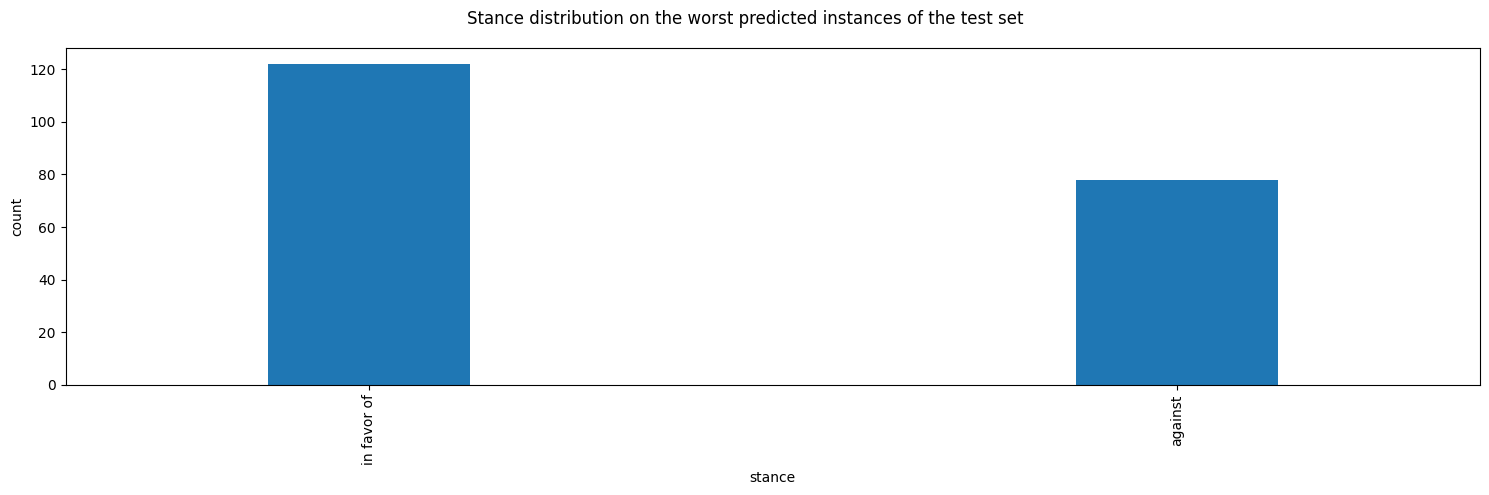

In [32]:
from src.datasets.dataset_analysis import plot_stance_distribution

plot_stance_distribution(worst_predicted_instances,
                         title='Stance distribution on the worst predicted instances of the test set')

Finally, the worst $5$ instances in terms of accuracy predictions are shown. It is interesting to point out that $3$ of them are about religion, possibly making it a controversial or multi-informative topic.

In [33]:
from src.evaluation.error_analysis import print_k_worst_predicted_instances

print_k_worst_predicted_instances(worst_predicted_instances, y_true, y_pred,
                                  TARGETS, n_worst_instances=5)

Worst instance 1:
-----------------
Premise: "the vow of celibacy is too important to do away with.  it shows that there is nothing more important than the church and is a true goal worth striving for."
Stance: "against"
Conclusion: "The vow of celibacy should be abandoned"
True targets: "Achievement; Face; Tradition; Conformity: rules; Humility"
Predicted targets: "Self-direction: action; Security: societal; Benevolence: caring; Universalism: concern; Universalism: objectivity"

Worst instance 2:
-----------------
Premise: "the vow of celibacy should be abandoned because it is outdated and usually causes more harm than good because the celibate person looks for release in the wrong places."
Stance: "in favor of"
Conclusion: "The vow of celibacy should be abandoned"
True targets: "Stimulation; Hedonism; Face; Conformity: rules; Humility; Benevolence: dependability"
Predicted targets: "Self-direction: action; Benevolence: caring; Universalism: concern; Universalism: objectivity"

Worst 